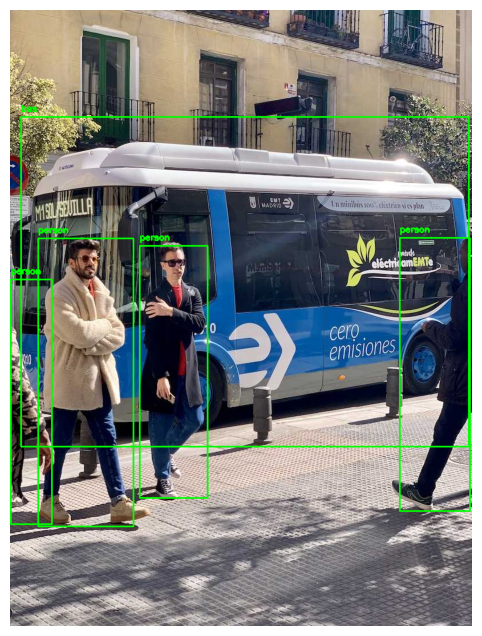

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load YOLOv3 weights and configuration file
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Load class names from the coco.names file
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load image
img = cv2.imread("bus.jpg")
if img is None:
    print("Error: Image not found or unable to load.")
else:
    height, width, channels = img.shape

    # Convert BGR image to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create a blob for YOLO input
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    # Set the input to the network
    net.setInput(blob)

    # Get the names of all layers
    layer_names = net.getLayerNames()

    # Output layers are the final layers (i.e., "output" layers)
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Perform a forward pass through the network
    outs = net.forward(output_layers)

    # Process the detection results
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Confidence threshold
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = center_x - w // 2
                y = center_y - h // 2
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maxima suppression to remove redundant boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Display the detected objects
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert the image to RGB for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Use matplotlib to show the image
    plt.figure(figsize=(8,8))
    plt.imshow(img_rgb)
    plt.axis('off')  
    plt.show()


In [10]:
import cv2
import numpy as np

# Load YOLOv3 weights and configuration file
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Load class names from the coco.names file
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load the video
cap = cv2.VideoCapture("library1.mp4")

# Get video properties for output video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define codec and create VideoWriter object to save the processed video
out = cv2.VideoWriter("output_video.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()  # Read a frame from the video
    if not ret:
        break  # If no frame is returned, exit the loop

    # Prepare the frame for YOLO detection
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    output_layers = net.getUnconnectedOutLayersNames()
    detections = net.forward(output_layers)

    # Process detections
    class_ids = []
    confidences = []
    boxes = []

    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)  # Get class ID with the highest score
            confidence = scores[class_id]  # Get the confidence score
            if confidence > 0.5:  # Filter out weak detections
                center_x = int(obj[0] * frame.shape[1])
                center_y = int(obj[1] * frame.shape[0])
                w = int(obj[2] * frame.shape[1])
                h = int(obj[3] * frame.shape[0])

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])  # Store the bounding box
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maxima suppression to remove overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw bounding boxes and class labels on the frame
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])  # Class label
            color = (0, 255, 0)  # Green color for bounding box
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Write the processed frame to the output video
    out.write(frame)

# Release resources
cap.release()
out.release()

print("Video processing complete. Output saved as 'output_video.mp4'.")


Video processing complete. Output saved as 'output_video.mp4'.
